# Análise de Subtipos Moleculares

Este notebook integra todas as etapas do fluxo de trabalho para análise de subtipos moleculares, utilizando os módulos modularizados.

### **Configuração Inicial e Importações**

In [1]:
# Importações padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import shap

# Importar módulos personalizados
from modules.data_loader import DataLoader
from modules.preprocessor import Preprocessor
from modules.modeling import RandomForestKFoldRunner
from modules.visualization import Visualization

In [2]:
# Configurar diretórios
data_dir = 'datas'
output_dir = 'outputs'
results_dir = 'results'

# Criar diretórios se não existirem
for directory in [output_dir, results_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# **Etapa 1. Geração da Tabela de Genes Vs Subtipos**

### 1.1. Carregamento de Dados

In [3]:
# Inicializar o carregador de dados
data_loader = DataLoader(data_dir=data_dir)

# Carregar dados clínicos
clinical_data = data_loader.load_clinical_data()
clinical_data.head()

,Sample ID,Subtype
0,TCGA-BR-8077-01,STAD_CIN
1,TCGA-BR-8289-01,STAD_CIN
2,TCGA-BR-8291-01,STAD_CIN
3,TCGA-F1-6875-01,STAD_CIN
4,TCGA-D7-8574-01,STAD_GS


### Informações sobre o conjunto de dados

**Subtipos Moleculares**

In [4]:
# Estatísticas dos subtipos
subtype_stats = data_loader.get_subtype_statistics(clinical_data)

Quantidade total de casos: 383

Quantidade de casos por subtipo:
Subtype
STAD_CIN     223
STAD_MSI      73
STAD_GS       50
STAD_EBV      30
STAD_POLE      7
Name: count, dtype: int64
Porcentagem por classe:
CIN: 58.22%
MSI: 19.06%
GS: 13.05%
EBV: 7.83%
POLE: 1.83%


**SNV**

In [5]:
# Carregar dados somáticos
somatic_data = data_loader.load_somatic_data()
somatic_data.head()

,gene,Sample_ID,effect
0,CLSTN1,TCGA-BR-7723-01A,missense_variant
1,PNRC2,TCGA-BR-7723-01A,frameshift_variant
2,AGBL4,TCGA-BR-7723-01A,intron_variant
3,LRRIQ3,TCGA-BR-7723-01A,missense_variant
4,TNNI3K,TCGA-BR-7723-01A,missense_variant


In [6]:
print(f"Quanditade total de amostras: {len(somatic_data['Sample_ID'])}")
print(f"Quantidade de casos diferentes: {len(somatic_data['Sample_ID'].unique())}")

Quanditade total de amostras: 187748
Quantidade de casos diferentes: 433


### 1.2. Pré-processamento de Dados

In [7]:
# Inicializar o pré-processador
preprocessor = Preprocessor(output_dir=output_dir)

# Mesclar dados clínicos e somáticos
merged_df = preprocessor.merge_clinical_and_somatic(clinical_data, somatic_data)
merged_df.head()

,Sample ID,Subtype,gene,effect
0,TCGA-BR-8077,STAD_CIN,MACF1,missense_variant
1,TCGA-BR-8077,STAD_CIN,GTF2B,missense_variant
2,TCGA-BR-8077,STAD_CIN,NBPF9,missense_variant
3,TCGA-BR-8077,STAD_CIN,S100A7L2,missense_variant
4,TCGA-BR-8077,STAD_CIN,APOA2,synonymous_variant


### 1.3 - Fazendo operações na tabela mesclada

As amostras que possuem na coluna `effect` o valor `synonymous_variant` são irrelevantes para esse estudo. Por isso serão exluida todas as amostras com esse valor. 

In [8]:
# Criar matriz de genes
gene_matrix = preprocessor.create_gene_matrix(somatic_data, merged_df)
print(f"Dimensões da matriz de genes: {gene_matrix.shape}")
gene_matrix.head()

Foram excluídas: 57946 amostras
Restando:
- Casos: 378
- Amostras: 129802

Distribuição dos subtipos após remoção de POLE:
Subtype
STAD_CIN    223
STAD_MSI     73
STAD_GS      45
STAD_EBV     30
Name: count, dtype: int64

Dimensões finais do dataset: (371, 18293)

✅ Arquivo salvo em: outputs\gene_subtype_table.csv
Dimensões da matriz de genes: (371, 18293)


gene,Sample ID,Subtype,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,ago.1,ago.2,ago.3,ago.4,pk
0,TCGA-3M-AB46,cin,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-3M-AB47,gs,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-B7-5816,msi,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-B7-5818,ebv,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-B7-A5TI,msi,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Etapa 2. K-Fold e Geração dos valores SHAP**

Uma vez gereda a tabela dos genes e subtipos moleculares, executa o k-fold para obter os valores SHAP de cada gene.

### 2.1. Visualização Exploratória

In [9]:
# Inicializar o visualizador
viz = Visualization(output_dir=output_dir)

c:\Users\Fernando Alves\Desktop\G.SubtForest\modules\visualization.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


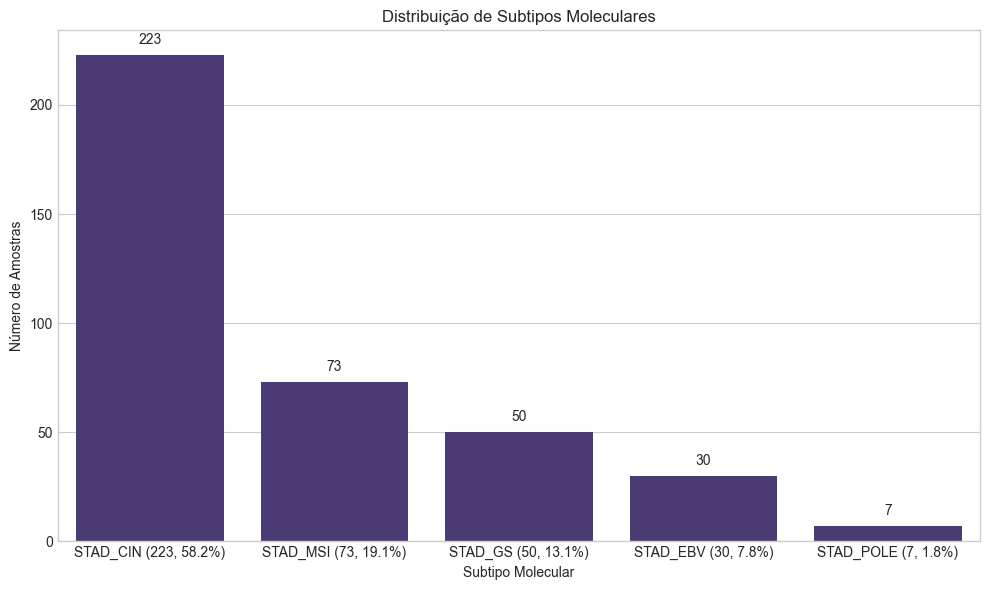

In [10]:
# Plotar distribuição de subtipos
fig_dist = viz.plot_subtype_distribution(clinical_data)
viz.save_figure(fig_dist, 'subtype_distribution')
fig_dist

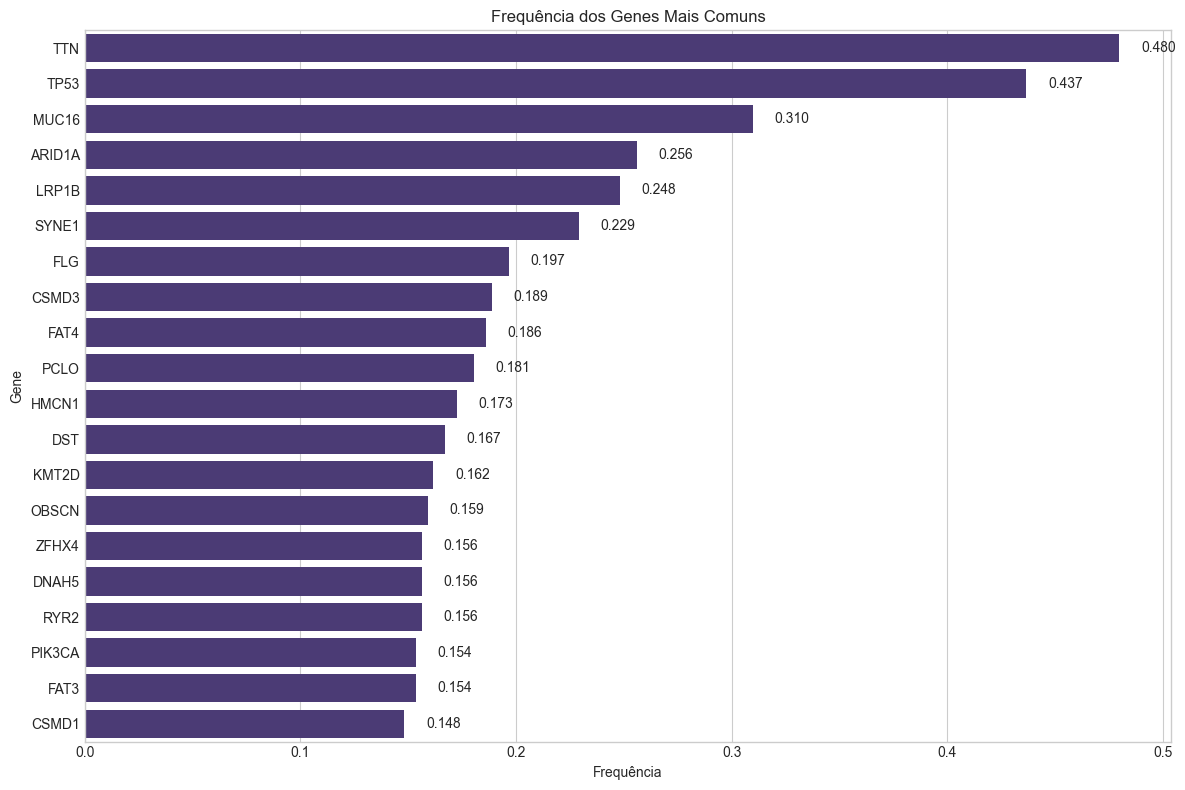

In [11]:
# Plotar frequência de genes
df_final = pd.read_csv('outputs/gene_subtype_table.csv')
fig_freq = viz.plot_gene_frequency(df_final, top_n=20)
viz.save_figure(fig_freq, 'gene_frequency_top20')
fig_freq


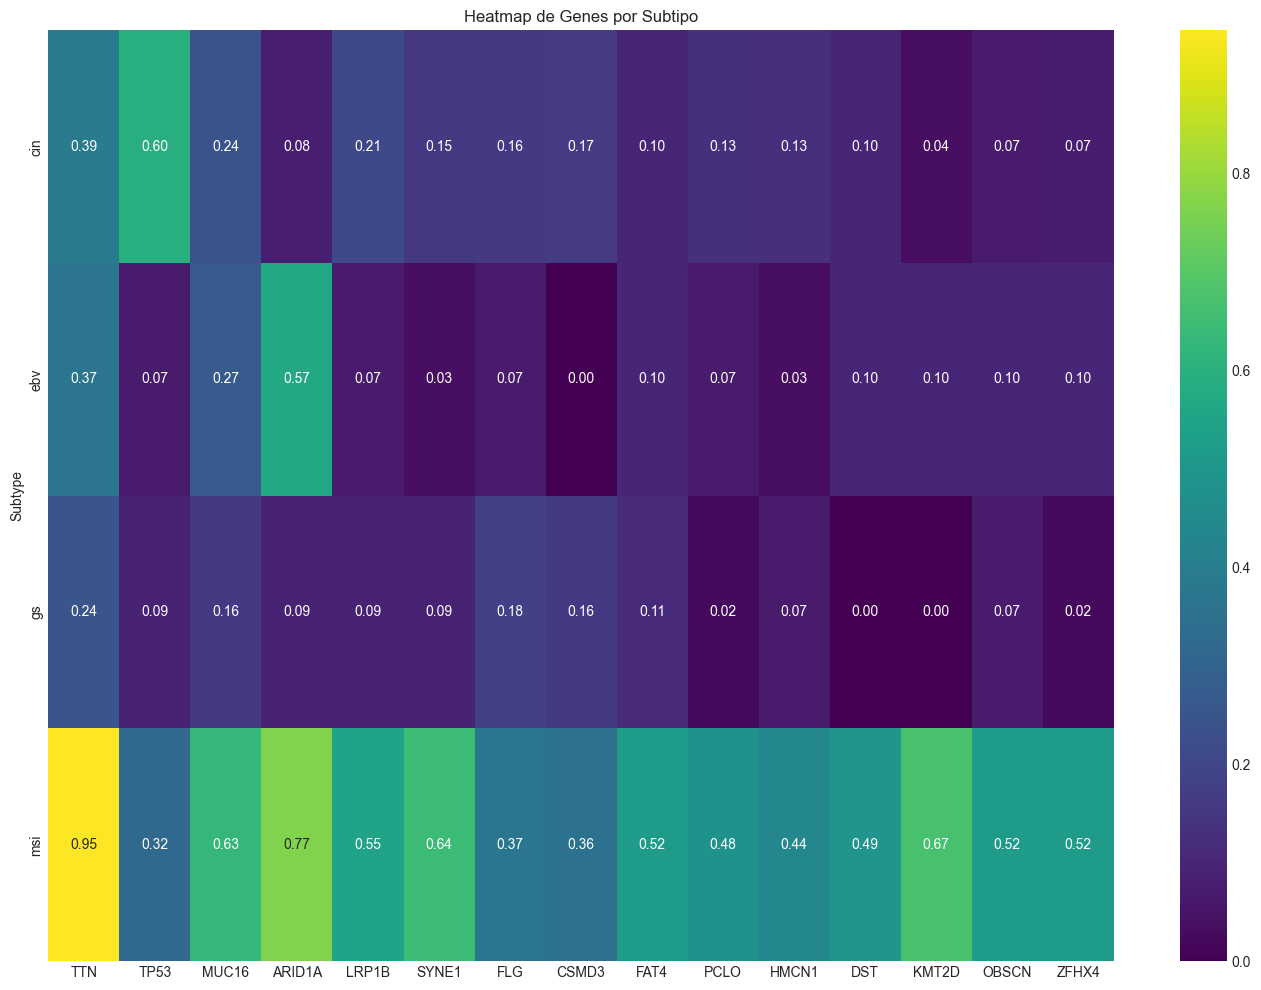

In [12]:
# Plotar heatmap de genes por subtipo
fig_heatmap = viz.plot_gene_subtype_heatmap(df_final, top_n=15)
viz.save_figure(fig_heatmap, 'gene_subtype_heatmap')
fig_heatmap


### 2.2. Preparação para Modelagem

##### Separando grupo teste hold out
`Verificando se a lista dos casos de test utilizados como teste para o ensemble estão no conjunto dos casos restantes`

In [13]:
test_list = ['TCGA-D7-A6EY', 'TCGA-CD-A48C', 'TCGA-D7-5578', 'TCGA-CG-4469', 'TCGA-HU-A4GD', 'TCGA-BR-8371', 'TCGA-CD-A4MJ', 'TCGA-BR-8291', 'TCGA-RD-A8N4', 'TCGA-BR-6801', 'TCGA-CG-4462', 'TCGA-RD-A8N2', 'TCGA-D7-6822', 'TCGA-CD-8530', 'TCGA-D7-A748', 'TCGA-HU-A4H3', 'TCGA-HF-A5NB', 'TCGA-BR-7715', 'TCGA-D7-A6EZ', 'TCGA-B7-A5TN', 'TCGA-HF-7136', 'TCGA-CG-4444', 'TCGA-D7-6518', 'TCGA-BR-7723', 'TCGA-RD-A7BS', 'TCGA-D7-6521', 'TCGA-BR-6707', 'TCGA-BR-A4IZ', 'TCGA-D7-A747', 'TCGA-VQ-A8PD', 'TCGA-VQ-A923', 'TCGA-D7-A6F0', 'TCGA-HU-A4H8', 'TCGA-VQ-A8PF', 'TCGA-HU-A4GF', 'TCGA-BR-7196', 'TCGA-BR-6852', 'TCGA-BR-7959', 'TCGA-VQ-A8P8', 'TCGA-BR-7957', 'TCGA-BR-8590', 'TCGA-MX-A5UJ', 'TCGA-BR-8679', 'TCGA-BR-6566', 'TCGA-D7-8572', 'TCGA-VQ-AA69', 'TCGA-HF-7132', 'TCGA-CG-4443', 'TCGA-VQ-A8PB', 'TCGA-BR-4279', 'TCGA-CD-8535', 'TCGA-CD-A486', 'TCGA-VQ-A8PX', 'TCGA-HU-8604', 'TCGA-MX-A5UG', 'TCGA-BR-4357', 'TCGA-HU-A4G9', 'TCGA-BR-A4QI', 'TCGA-HU-A4GU', 'TCGA-BR-A452', 'TCGA-D7-6519', 'TCGA-D7-8570', 'TCGA-HU-A4H6', 'TCGA-CG-5720', 'TCGA-BR-7901', 'TCGA-BR-6706', 'TCGA-BR-8687', 'TCGA-VQ-A928', 'TCGA-BR-8081', 'TCGA-3M-AB47', 'TCGA-CG-4436', 'TCGA-BR-8058', 'TCGA-VQ-A91W', 'TCGA-BR-4361', 'TCGA-BR-4370', 'TCGA-D7-A6EX', 'TCGA-BR-7707', 'TCGA-CG-4477', 'TCGA-CG-5726', 'TCGA-BR-4253', 'TCGA-D7-A6F2', 'TCGA-HU-8249']

In [14]:
# Dividir em treino/validação e teste
X_train_val, y_train_val, X_test, y_test, sample_ids, train_val_df, test_df = preprocessor.create_train_test_split(test_list, df_final)


Casos que estão na lista dos casos usados para o teste do ensemble mas não estão nos casos restantes das tabelas mesclada de subtipos e genes
['TCGA-RD-A8N2']
Quantidade de casos que serão separados para o dataset de teste: 81
Dimensções do data frame de teste: (81, 18293)
Dimensções do data frame de de teste e validação: (290, 18293)
Distribuição no dataset de teste:
Subtype
cin    41
msi    18
gs     12
ebv    10
Name: count, dtype: int64


### 2.3. **Modelagem com Random Forest** - Treinando Modelos e Obtendo Valores SHAP

In [15]:
# Treinar e avaliar modelo com K-Fold CV
runner = RandomForestKFoldRunner(
    n_splits=10,
    random_state=42,
    output_dir="outputs",
    n_iter_search=10
)

results = runner.run(X_train_val, y_train_val, train_val_df)



🚀 Executando Fold 1/10
Resultados do fold 0 salvos em: outputs\kfold_random_forest_results\rf_test_df_fold0_results.csv

Classification Report Fold 0:
              precision  recall  f1-score  support
cin                0.79    0.58      0.67    19.00
ebv                0.00    0.00      0.00     2.00
gs                 0.20    0.67      0.31     3.00
msi                1.00    1.00      1.00     5.00
accuracy           0.62    0.62      0.62     0.62
macro avg          0.50    0.56      0.49    29.00
weighted avg       0.71    0.62      0.64    29.00

🚀 Executando Fold 2/10
Resultados do fold 1 salvos em: outputs\kfold_random_forest_results\rf_test_df_fold1_results.csv

Classification Report Fold 1:
              precision  recall  f1-score  support
cin                0.80    0.63      0.71    19.00
ebv                0.00    0.00      0.00     2.00
gs                 0.22    0.67      0.33     3.00
msi                1.00    1.00      1.00     5.00
accuracy           0.66    0.66  

# **Etapa 3 - Gerando Métricas de Avaliação dos Modelos**

## 7. Análise de Importância de Features

## 8. Análise de Valores SHAP

## 9. Criação de Painéis Genéticos

## 10. Avaliação dos Painéis Genéticos

## 11. Tabela de Resultados

## 12. Conclusões

Neste notebook, realizamos uma análise completa de subtipos moleculares utilizando Random Forest e análise SHAP:

1. Carregamos e pré-processamos dados clínicos e somáticos
2. Criamos uma matriz de genes e filtramos genes raros
3. Treinamos modelos Random Forest com validação cruzada e otimização de hiperparâmetros
4. Analisamos a importância das features e valores SHAP
5. Criamos painéis genéticos baseados em importância SHAP
6. Avaliamos o desempenho de cada painel genético

Os resultados mostram que o painel com melhor desempenho foi [inserir conclusão baseada nos resultados], com acurácia média de [inserir valor] e F1-Score médio de [inserir valor].